In [135]:
import utils
import math
import re
import itertools
from typing import NamedTuple
from collections import defaultdict, deque
import itertools
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt

## Day 12: Rain Risk

[#](https://adventofcode.com/2020/day/12). We have a ship facing east and a list of single letter instructions to turn it by degree and others to move it Forward or in a given E,W,N,S direction.

Since the ship starts out facing east, I'll consider that degree zero and 

In [187]:
test12 = """F10
N3
F7
R90
F11""".splitlines()

inp12 = utils.get_input(12, splitlines=True)

def parse_12(inp=test12):
    return [(row[0], int(row[1:])) for row in inp]

instructions = parse_12()
instructions

[('F', 10), ('N', 3), ('F', 7), ('R', 90), ('F', 11)]

In [189]:
def manhatten(x, y, origin=(0,0)):
    """returns manhatten distance to origin"""
    return abs(x - origin[0]) + abs(y - origin[1])

manhatten(3, 5)

8

In [190]:
# assuming direction is only in 90 degree jumps
directions = {0: "E", 90: "S", 180: "W", 270: "N"}

def rotate(degree, ins, num):
    """takes in heading and angle to rotate by, returns new heading"""
    assert ins == "L" or ins == "R"
    #print(f"{degree=}")
    
    # left is negative, right is positive
    deg = {"L": -1, "R": 1}[ins] * num
    degree += deg
    #print(f"{degree=} {deg=}")
    return degree % 360
        
rotate(90, "R", 360), rotate(0, "R", 90)

(90, 90)

ins='F' num=10 degree=0
  New direction after ins='E' degree=0 num=10
    Moved to 10 y=0 ins='E'
ins='N' num=3 degree=0
    Moved to 10 y=3 ins='N'
ins='F' num=7 degree=0
  New direction after ins='E' degree=0 num=7
    Moved to 17 y=3 ins='E'
ins='R' num=90 degree=0
    Moved to 17 y=3 ins='R'
ins='F' num=11 degree=90
  New direction after ins='S' degree=90 num=11
    Moved to 17 y=-8 ins='S'
[(0, 0), (10, 0), (10, 3), (17, 3), (17, 3), (17, -8)]


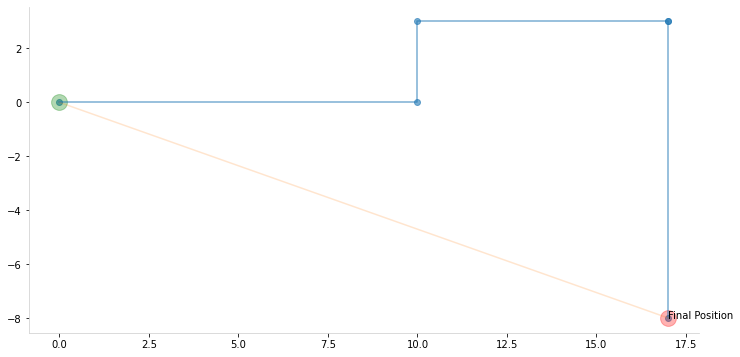

25

In [209]:
def solve_12(inp=test12, x=0, y=0, degree=0, debug=False):
    
    instructions = parse_12(inp)
    positions = [(x,y)]
    
    for ins, num in instructions:
        if debug: print(f"{ins=} {num=} {degree=}")
        
        # convert Forward ins into a E,W,S,N
        if ins == "F":
            ins = directions[degree]
            if debug: print(f"  New direction after {ins=} {degree=} {num=}")
        
        # rotate heading
        if ins == "L" or ins == "R":
            degree = rotate(degree, ins, num)
            
        # move
        if ins == "E":
            x += num
        elif ins == "W":
            x -= num
        elif ins == "N":
            y += num
        elif ins == "S":
            y -= num
            
        if debug: print(f"    Moved to {x} {y=} {ins=}")
        positions.append((x,y))
    
    if debug: print(positions)
    
    # plot
    X, Y = zip(*positions)
    fig = plt.figure(figsize=(12,6))
    plt.scatter(X, Y, alpha=.6)
    
    # highlight points
    plt.scatter(X[0], Y[0], color="green", alpha=0.3, s=250)
    plt.scatter(X[-1], Y[-1], color="red", alpha=0.3, s=250)
    plt.annotate("Final Position", (X[-1], Y[-1])                )
    plt.plot(X, Y, alpha=0.6)
    plt.plot((0, X[-1]), (0, Y[-1]), alpha=0.2)
    plt.show()

    return manhatten(x,y)

#assert solve_12() == 25
solve_12(test12, debug=True)

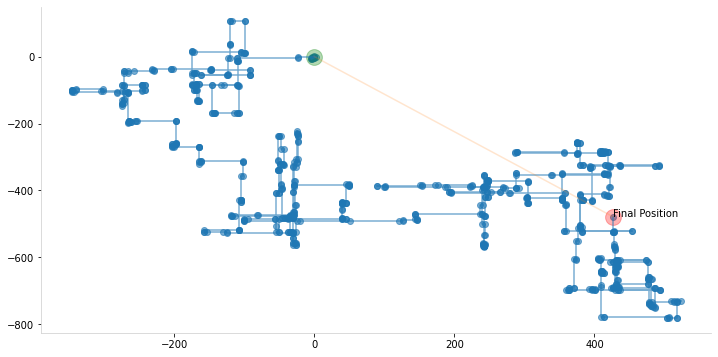

904

In [210]:
solve_12(inp12)

## Part 2

Now the waypoint is relative to the ship, and the instructions can move either the ship or the waypoint.

`F` moves the ship to the waypoint `num` times. Since the waypoint is relative to the ship the absolute waypoint position also changes when the ship moves.

To make this easier to track, I'm putting the above into a class.

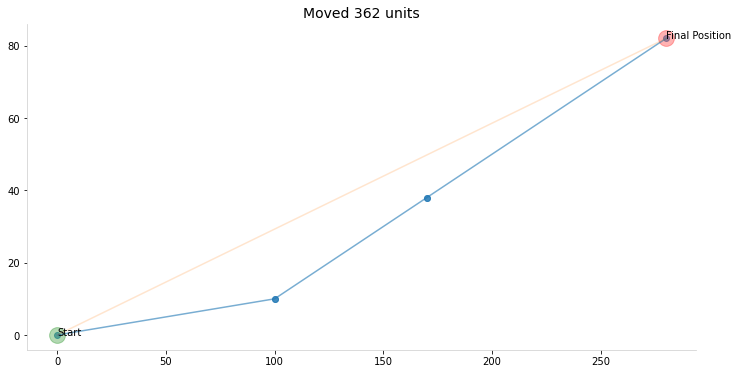

(None, 362, None)

In [282]:
class Ship:
    def __init__(self, inp=test12, 
                 degree=0, position=(0, 0), waypoint=(10, 1)):
        
        self.instructions = parse_12(inp)
        self.degree = degree
        self.x, self.y = position # current position
        self.xw, self.yw = waypoint # waypoint position
        self.directions = {0: "E", 90: "S", 180: "W", 270: "N"}
        self.positions = [position] # all the points travelled to
        
    def manhatten(self, origin=(0,0)):
        """returns manhatten distance to origin"""
        return abs(self.x) + abs(self.y)

    def rotate(self, degree, ins, num):
        """takes in heading and angle to rotate by, returns new heading"""
        degree += {"L": -1, "R": 1}[ins] * num
        return degree % 360
    
    def move_waypoint(self, ins, num):
        if ins == "E":
            self.xw += num
        elif ins == "W":
            self.xw -= num
        elif ins == "N":
            self.yw += num
        elif ins == "S":
            self.yw -= num
        
    def rotate_waypoint(self, ins, num):
        degree = self.rotate(ins, num)
        print(degree)
        pass
    
    def do(self):
        debug=False
        for ins, num in self.instructions:
            if debug: print(f"{ins=} {num=} {degree=}")

            # move ship to waypoint num times
            if ins == "F":
                self.x += self.xw * num
                self.y += self.yw * num

            # rotate waypoint
            if ins == "L" or ins == "R":
                self.degree = rotate(self.degree, ins, num)

            # move
            self.move_waypoint(ins, num)
            
            self.positions.append((self.x,self.y))
        
    def plot(self):
        X, Y = zip(*self.positions)
        fig = plt.figure(figsize=(12,6))
        plt.scatter(X, Y, alpha=.6)
        plt.title(f"Moved {self.manhatten():,} units")

        # highlight points
        plt.scatter(X[0], Y[0], color="green", alpha=0.3, s=250)
        plt.scatter(X[-1], Y[-1], color="red", alpha=0.3, s=250)
        plt.annotate("Start", (X[0], Y[0]))
        plt.annotate("Final Position", (X[-1], Y[-1]))
        plt.plot(X, Y, alpha=0.6)
        plt.plot((0, X[-1]), (0, Y[-1]), alpha=0.2)
        plt.show()
    
ship = Ship(test12)
ship.do(), ship.manhatten(), ship.plot()

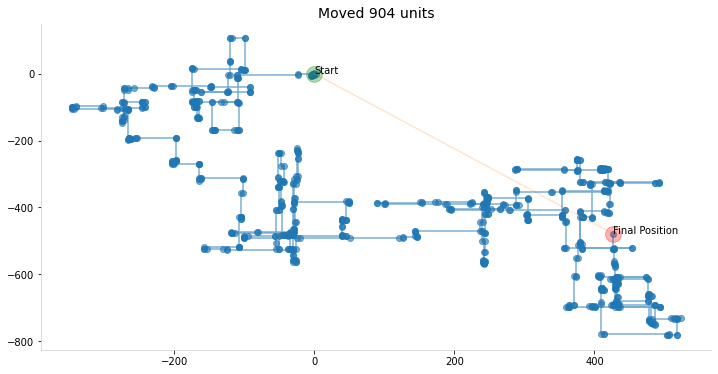

(None, 904, None)

In [280]:
ship = Ship(inp12)
ship.do(), ship.manhatten(), ship.plot()